YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:32:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[519  40]
 [  6   1]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9886    0.9284    0.9576       559
           1     0.0244    0.1429    0.0417         7

    accuracy                         0.9187       566
   macro avg     0.5065    0.5357    0.4996       566
weighted avg     0.9766    0.9187    0.9462       566




[*********************100%***********************]  1 of 1 completed


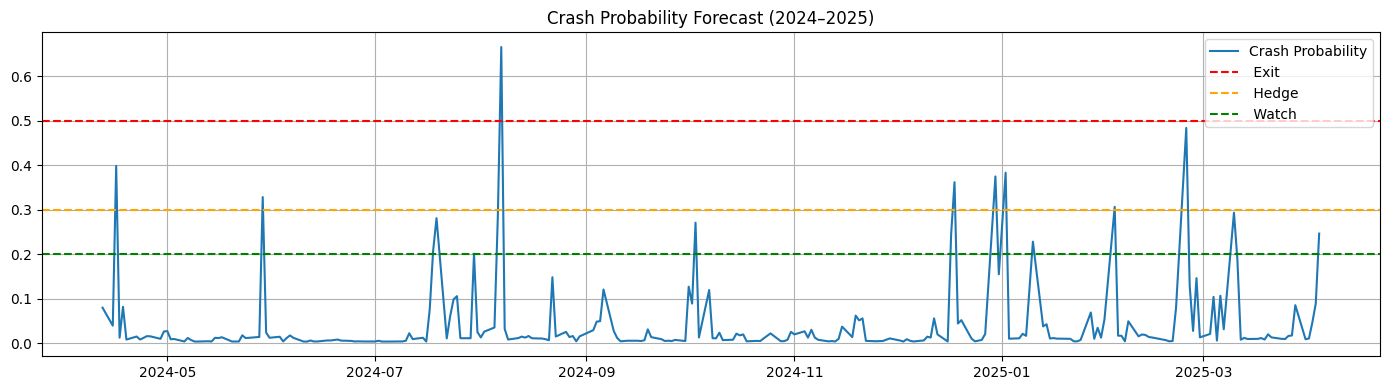

Empty DataFrame
Columns: [Crash_Probability, Action]
Index: []


In [ ]:

# Stock Market Crash Prediction using SPY & VIX (XGBoost)
# Author: Sruthi Vippaturi

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Loading SPY & VIX historical data
spy = yf.download("SPY", start="2013-01-01", end="2024-04-05")
vix = yf.download("^VIX", start="2013-01-01", end="2024-04-05")

# Combining  and engineer features
df = pd.DataFrame()
df['SPY_Close'] = spy['Close']
df['VIX_Close'] = vix['Close']
df.dropna(inplace=True)

df['SPY_Return'] = df['SPY_Close'].pct_change()
df['VIX_Return'] = df['VIX_Close'].pct_change()
df['SPY_3d_Volatility'] = df['SPY_Return'].rolling(3).std()
df['VIX_3d_Change'] = df['VIX_Close'].pct_change(periods=3)
df['VIX_to_SPY'] = df['VIX_Close'] / df['SPY_Close']
df['SPY_5d_Return'] = df['SPY_Close'].pct_change(periods=5)
df['SPY_5d_Volatility'] = df['SPY_Return'].rolling(5).std()
df['VIX_5d_Change'] = df['VIX_Close'].pct_change(periods=5)

df['Future_2d_Return'] = df['SPY_Close'].pct_change(periods=2).shift(-2)
df['Crash'] = df['Future_2d_Return'].apply(lambda x: 1 if x <= -0.04 else 0)
df.dropna(inplace=True)

# features and target
features = ['VIX_Close', 'SPY_Return', 'VIX_Return', 'SPY_3d_Volatility',
            'VIX_3d_Change', 'VIX_to_SPY', 'SPY_5d_Return', 'SPY_5d_Volatility', 'VIX_5d_Change']
X = df[features]
y = df['Crash']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Training XGBoost classifier
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4,
                      scale_pos_weight=scale_pos_weight, use_label_encoder=False,
                      eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predicting crash probabilities
probs = model.predict_proba(X_test)[:, 1]
y_pred = (probs >= 0.2).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Predict future
future_spy = yf.download("SPY", start="2024-04-05", end="2025-12-31")
future_vix = yf.download("^VIX", start="2024-04-05", end="2025-12-31")

future_df = pd.DataFrame()
future_df['SPY_Close'] = future_spy['Close']
future_df['VIX_Close'] = future_vix['Close']
future_df.dropna(inplace=True)

future_df['SPY_Return'] = future_df['SPY_Close'].pct_change()
future_df['VIX_Return'] = future_df['VIX_Close'].pct_change()
future_df['SPY_3d_Volatility'] = future_df['SPY_Return'].rolling(3).std()
future_df['VIX_3d_Change'] = future_df['VIX_Close'].pct_change(periods=3)
future_df['VIX_to_SPY'] = future_df['VIX_Close'] / future_df['SPY_Close']
future_df['SPY_5d_Return'] = future_df['SPY_Close'].pct_change(periods=5)
future_df['SPY_5d_Volatility'] = future_df['SPY_Return'].rolling(5).std()
future_df['VIX_5d_Change'] = future_df['VIX_Close'].pct_change(periods=5)
future_df.dropna(inplace=True)

future_X = future_df[features]
future_df['Crash_Probability'] = model.predict_proba(future_X)[:, 1]

# Define action
def assign_action(prob):
    if prob >= 0.5:
        return "Exit"
    elif prob >= 0.3:
        return "Hedge"
    elif prob >= 0.2:
        return "Watch"
    else:
        return "Hold"

future_df['Action'] = future_df['Crash_Probability'].apply(assign_action)

# Plot results
plt.figure(figsize=(14, 4))
plt.plot(future_df.index, future_df['Crash_Probability'], label='Crash Probability')
plt.axhline(0.5, color='red', linestyle='--', label=' Exit')
plt.axhline(0.3, color='orange', linestyle='--', label=' Hedge')
plt.axhline(0.2, color='green', linestyle='--', label=' Watch')
plt.title('Crash Probability Forecast (2024–2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show next 7 days
today = pd.Timestamp.today().normalize()
next_week = today + pd.Timedelta(days=7)
print(future_df[(future_df.index >= today) & (future_df.index <= next_week)][['Crash_Probability', 'Action']])

In [ ]:
# Check prediction for April 4th, 2025
april_4_2025_pred = future_df.loc['2025-04-04', ['Crash_Probability', 'Action']]
print("Prediction for April 4th, 2025:")
print(april_4_2025_pred)


Prediction for April 4th, 2025:
Crash_Probability    0.246588
Action                  Watch
Name: 2025-04-04 00:00:00, dtype: object
